In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
import seaborn as sns

## Load Data

In [2]:
train = pd.read_csv('loan_2017_hist.csv')
test = pd.read_csv('loan_2017_curr.csv')

/Users/andyjin/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (118) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
train.shape

(324613, 150)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324613 entries, 0 to 324612
Columns: 150 entries, id to settlementterm
dtypes: float64(56), int64(57), object(37)
memory usage: 371.5+ MB


## Select Data

In [5]:
df = train.append(test)
df.shape

(443139, 150)

In [6]:
cols = df.columns

In [7]:
all_null_feature=[]
num_feature=[]
ob_feature=[]

for col in cols:
    if df[col].isnull().sum()==df.shape[0]:
        all_null_feature.append(col)
    else:
        if df[col].dtype == 'object':
            ob_feature.append(col)
        else:
            num_feature.append(col)

In [8]:
print(all_null_feature)

['memberid', 'desc']


In [9]:
all_null_feature =['memberid', 'desc','secappopenactil',
 'secappnumrevaccts',
 'secappmthssincelastmajorderog',
 'secappcollections12mthsexmed',
 'revolbaljoint',
 'secappopenacc',
 'secappficorangelow',
 'memberid',
 'secappmortacc',
 'secappearliestcrline',
 'secappchargeoffwithin12mths',
 'secapprevolutil',
 'secappficorangehigh',
 'secappinqlast6mths']

In [10]:
ob_feature=['initialliststatus',
 'grade',
 'subgrade',
 'verificationstatusjoint',
 'earliestcrline',
 'applicationtype',
 'intrate',
 'desc',
 'term',
 'homeownership',
 'addrstate',
 'revolutil',
 'zipcode',
 'verificationstatus',
 'emptitle',
 'emplength',
 'purpose',
 'issued',
 'loanstatus']

In [11]:
num_feature=['bcopentobuy',
 'numactvbctl',
 'mthssincelastrecord',
 'totcurbal',
 'mosinrcnttl',
 'openrv12m',
 'inqlast12m',
 'mortacc',
 'mthssincelastdelinq',
 'numactvrevtl',
 'tothicredlim',
 'ficorangehigh',
 'maxbalbc',
 'openil24m',
 'numbctl',
 'totalrevhilim',
 'totcollamt',
 'numtl120dpd2m',
 'totalbalexmort',
 'annualincjoint',
 'ficorangelow',
 'totalacc',
 'mthssincerecentbcdlq',
 'installment',
 'numrevaccts',
 'pubrec',
 'accopenpast24mths',
 'numoprevtl',
 'avgcurbal',
 'openactil',
 'dti',
 'openacc6m',
 'totalbalil',
 'delinq2yrs',
 'fundedamnt',
 'mosinoldilacct',
 'annualinc',
 'inqfi',
 'numtl30dpd',
 'loanamnt',
 'numsats',
 'mthssincerecentrevoldelinq',
 'mthssincerecentbc',
 'id',
 'revolbal',
 'inqlast6mths',
 'mthssincercntil',
 'openrv24m',
 'totalilhighcreditlimit',
 'collections12mthsexmed',
 'chargeoffwithin12mths',
 'numtl90gdpd24m',
 'delinqamnt',
 'mosinoldrevtlop',
 'taxliens',
 'numbcsats',
 'totalbclimit',
 'dtijoint',
 'numacctsever120pd',
 'accnowdelinq',
 'openil12m',
 'pcttlnvrdlq',
 'bcutil',
 'mthssincerecentinq',
 'numiltl',
 'mosinrcntrevtlop',
 'allutil',
 'openacc',
 'numrevtlbalgt0',
 'totalcutl',
 'mthssincelastmajorderog',
 'numtloppast12m',
 'percentbcgt75',
 'pubrecbankruptcies',
 'ilutil']

In [12]:
select_feature=ob_feature+num_feature
len(select_feature)

94

In [13]:
# remove fundedamnt since it always equals to 1 for issued loans and varied during different time of a current loan
num_feature.remove('fundedamnt')

In [14]:
# remove 'id','issued' and 'loanstatus', since they are index, train/test flag and target
num_feature.remove('id')
ob_feature.remove('loanstatus')
ob_feature.remove('issued')

In [15]:
# remove 'desc' from ob_feature and select_feature
ob_feature.remove('desc')

In [16]:
select_feature=ob_feature+num_feature
len(select_feature)

89

In [17]:
# selected features left
df=df[select_feature+['id','loanstatus','issued']]

In [18]:
df.shape

(443139, 92)

## only use term=36 months and loanstatus = fully paid and charged off

In [19]:
df = df.query("loanstatus == 'Fully Paid' or loanstatus == 'Charged Off' ")

In [20]:
df = df.query("term ==' 36 months'")

In [21]:
df.shape

(207410, 92)

In [22]:
df.drop('term', axis = 1, inplace=True)

In [23]:
df.shape

(207410, 91)

In [24]:
ob_feature.remove('term')

## Label Target

In [25]:
df['loanstatus'] = df.loanstatus.map({"Charged Off": 1, "Fully Paid": 0})

In [26]:
print(df.loanstatus.value_counts())
print(df.loanstatus.value_counts(normalize=True))

0    167212
1     40198
Name: loanstatus, dtype: int64
0    0.806191
1    0.193809
Name: loanstatus, dtype: float64


## Out of time testing set and in-time training set: Oct~Dec as test)

In [27]:
issued=list(df['issued'].unique())
issued

['Mar-17',
 'Feb-17',
 'Jan-17',
 'Jun-17',
 'May-17',
 'Apr-17',
 'Sep-17',
 'Aug-17',
 'Jul-17',
 'Dec-17',
 'Nov-17',
 'Oct-17']

In [28]:
df['train_flg'] = df.issued.apply(lambda x: 0 if x in ['Oct-17','Nov-17','Dec-17'] else 1)
df.train_flg.value_counts()

1    163501
0     43909
Name: train_flg, dtype: int64

In [29]:
df.drop('issued', axis = 1, inplace=True)

In [30]:
df.shape

(207410, 91)

## Feature Engineering & Cleaning

#### Datetime to numeric feature

In [31]:
ob_feature

['initialliststatus',
 'grade',
 'subgrade',
 'verificationstatusjoint',
 'earliestcrline',
 'applicationtype',
 'intrate',
 'homeownership',
 'addrstate',
 'revolutil',
 'zipcode',
 'verificationstatus',
 'emptitle',
 'emplength',
 'purpose']

In [32]:
df.earliestcrline.unique()[:5]

array(['Apr-00', 'Aug-95', 'Oct-07', 'Apr-07', 'Apr-06'], dtype=object)

In [33]:
# convert to number of months to Dec 2017

In [34]:
cl_month=df.earliestcrline.apply(lambda x: x.split('-')[0])
cl_year=df.earliestcrline.apply(lambda x: int(x.split('-')[1]))

In [35]:
cl_month.unique()

array(['Apr', 'Aug', 'Oct', 'Jun', 'Sep', 'May', 'Dec', 'Jan', 'Mar',
       'Nov', 'Jul', 'Feb'], dtype=object)

In [36]:
cl_year.unique()

array([ 0, 95,  7,  6,  9,  5, 96, 73, 97,  1, 74, 92,  3,  4, 89, 93, 99,
        2, 94, 79, 91, 83, 88,  8, 10, 81, 90, 98, 13, 12, 85, 86, 11, 82,
       84, 80, 87, 77, 69, 66, 14, 78, 72, 68, 76, 75, 67, 65, 70, 60, 64,
       63, 71, 61, 52, 58, 53, 56, 59, 62, 57, 51, 34, 54])

In [37]:
dic_month= {'Jan':11,'Feb':10,'Mar':9,'Apr':8, 'May':7, 'Jun':6, 'Jul':5, 'Aug':4, 'Sep':3, 'Oct':2, 'Nov':1, 'Dec':0}

In [38]:
def months_till_dec_2017(date):
    year = int(date.split('-')[1])
    month = date.split('-')[0]
    
    if year < 17:
        year = 2000 + year
    else:
        year = 1900 + year
    
    return (2017 - year) * 12 + dic_month[month]

df['earliestcrline_month']=df.earliestcrline.apply(lambda x: months_till_dec_2017(x))

In [39]:
df.earliestcrline_month[:5]

4     212
5     268
6     122
9     128
11    140
Name: earliestcrline_month, dtype: int64

In [40]:
num_feature.append('earliestcrline_month')
ob_feature.remove('earliestcrline')

In [41]:
print(len(ob_feature), len(num_feature))

14 74


In [42]:
df.drop('earliestcrline', axis = 1, inplace=True)

In [43]:
df.shape

(207410, 91)

### emplength to numeric feature

In [44]:
print(df['emplength'].isnull().sum())
df['emplength'].unique()

15848


array(['10+ years', '6 years', '4 years', '3 years', '1 year', nan,
       '5 years', '8 years', '2 years', '< 1 year', '9 years', '7 years'],
      dtype=object)

In [45]:
df['emplength'].replace('n/a', np.nan, inplace=True)
df['emplength'].replace('< 1 year', '0', inplace=True)
df['emplength'].replace(to_replace='[^0-9]+', value='', inplace=True, regex=True)
df.emplength.fillna(value=-999,inplace=True)
df['emplength'] = df['emplength'].astype(int)

In [46]:
df.emplength.value_counts()

 10     65482
 2      19984
 0      19086
 3      17396
-999    15848
 1      14289
 4      13043
 5      12718
 6       9000
 7       7453
 9       6955
 8       6156
Name: emplength, dtype: int64

In [47]:
num_feature.append('emplength')
ob_feature.remove('emplength')
print(len(num_feature), len(ob_feature))

75 13


In [48]:
df.shape

(207410, 91)

## % to numeric feature: intrate, revolutil

In [49]:
intrate=df.intrate.apply(lambda x: float(x.replace('%','')))

In [50]:
df.intrate=intrate
df.intrate[:2]

4    11.39
5     6.99
Name: intrate, dtype: float64

In [51]:
df.revolutil = pd.Series(df.revolutil).str.replace('%', '').astype(float)

In [52]:
df.revolutil[:2]

4    30.0
5    24.0
Name: revolutil, dtype: float64

In [53]:
ob_feature.remove('intrate')
num_feature.append('intrate')
ob_feature.remove('revolutil')
num_feature.append('revolutil')

In [54]:
print(len(ob_feature), len(num_feature))

11 77


#### Ordinal feature encoding : grade, subgrade

In [55]:
Dic_grade = {"A": 1, 
            "B": 2, 
            "C": 3, 
            "D": 4, 
            "E": 5,
            "F": 6, 
            "G": 7}

In [56]:
df.grade = df.grade.map(Dic_grade)

In [57]:
df.subgrade = df.subgrade.apply(lambda x: (Dic_grade[x[0]] - 1) * 5 + int(x[1]))

In [58]:
ob_feature.remove('grade')
num_feature.append('grade')
ob_feature.remove('subgrade')
num_feature.append('subgrade')

In [59]:
print(len(ob_feature), len(num_feature))

9 79


### High cardinality feature encoding

###### Zip Code - frequency encoding 

In [60]:
df = df[df['zipcode'].notna()]
print(df.zipcode.nunique(), df.zipcode.unique()[:5])

889 ['761xx' '852xx' '983xx' '021xx' '307xx']


In [61]:
# convert zipcode to int
df.zipcode = df.zipcode.apply(lambda x: int(x[0:3]))

In [62]:
zipcode_freq = df.groupby("zipcode").size().reset_index()

In [63]:
zipcode_freq[:5]

,zipcode,0
0,8,1
1,10,307
2,11,115
3,12,76
4,13,42


In [64]:
zipcode_freq.columns = ["zipcode", "zipcode_freq"]

In [65]:
df = pd.merge(df, zipcode_freq, how = "left", on = "zipcode")

In [66]:
ob_feature.remove('zipcode')
num_feature.append('zipcode_freq')
num_feature.append('zipcode')

In [67]:
print(len(ob_feature), len(num_feature))

8 81


### emptitle-frequency encoding (can do some NLP for later stage)

In [68]:
emptitle_freq = df.groupby("emptitle").size().reset_index()
emptitle_freq.columns = ["emptitle", "emptitle_freq"]
df = pd.merge(df, emptitle_freq, how = "left", on = "emptitle")

In [69]:
df.drop("emptitle", axis = 1, inplace=True)

In [70]:
ob_feature.remove('emptitle')
num_feature.append('emptitle_freq')

In [71]:
print(len(ob_feature), len(num_feature))

7 82


###### Addr_state - frequency encoding

In [72]:
addrstate_freq = df.groupby("addrstate").size().reset_index()
addrstate_freq.columns = ["addrstate", "addrstate_freq"]
df = pd.merge(df, addrstate_freq, how = "left", on = "addrstate")

In [73]:
df.drop("addrstate", axis = 1, inplace=True)

In [74]:
ob_feature.remove('addrstate')
num_feature.append('addrstate_freq')
print(len(ob_feature), len(num_feature))

6 83


Binary features

In [75]:
ob_feature

['initialliststatus',
 'verificationstatusjoint',
 'applicationtype',
 'homeownership',
 'verificationstatus',
 'purpose']

In [76]:
# initialliststatus has only two values, change it to 0,1
initialliststatus= df.initialliststatus.apply(lambda x: 0 if x =='w' else 1)
df.initialliststatus = initialliststatus
df.initialliststatus.value_counts()

0    143547
1     63862
Name: initialliststatus, dtype: int64

In [77]:
# applicationtype has only two values (Individual, Joint), change it to 0,1; only less than 2% is 1.
applicationtype= df.applicationtype.apply(lambda x: 0 if x =='Individual' else 1)
df.applicationtype = applicationtype 
df.applicationtype.value_counts()

0    193667
1     13742
Name: applicationtype, dtype: int64

In [78]:
ob_feature.remove('initialliststatus')
num_feature.append('initialliststatus')
ob_feature.remove('applicationtype')
num_feature.append('applicationtype')
print(len(ob_feature), len(num_feature), ob_feature)

4 85 ['verificationstatusjoint', 'homeownership', 'verificationstatus', 'purpose']


In [79]:
# verificationstatusjoint mostly consistent with applicationtype, just remove it
ob_feature.remove('verificationstatusjoint')
print(len(ob_feature), len(num_feature), ob_feature)

3 85 ['homeownership', 'verificationstatus', 'purpose']


#### One hot encoding

In [80]:
dummy_feature = ["homeownership", "verificationstatus", "purpose"]

In [81]:
df_dummy = pd.get_dummies(df[dummy_feature])

In [82]:
OHE_feature=list(df_dummy.columns.values)

In [83]:
df_dummy.shape

(207409, 21)

In [84]:
df=pd.concat([df,df_dummy], axis=1 )

In [85]:
df.shape

(207409, 113)

In [86]:
df.drop(dummy_feature, axis = 1, inplace=True)

In [87]:
df.shape

(207409, 110)

In [88]:
for feat in dummy_feature:
    ob_feature.remove(feat)

In [89]:
select_feature=num_feature+OHE_feature

In [90]:
len(select_feature)

106

##  XGBoost 

In [91]:
feat=select_feature
print(feat)

['bcopentobuy', 'numactvbctl', 'mthssincelastrecord', 'totcurbal', 'mosinrcnttl', 'openrv12m', 'inqlast12m', 'mortacc', 'mthssincelastdelinq', 'numactvrevtl', 'tothicredlim', 'ficorangehigh', 'maxbalbc', 'openil24m', 'numbctl', 'totalrevhilim', 'totcollamt', 'numtl120dpd2m', 'totalbalexmort', 'annualincjoint', 'ficorangelow', 'totalacc', 'mthssincerecentbcdlq', 'installment', 'numrevaccts', 'pubrec', 'accopenpast24mths', 'numoprevtl', 'avgcurbal', 'openactil', 'dti', 'openacc6m', 'totalbalil', 'delinq2yrs', 'mosinoldilacct', 'annualinc', 'inqfi', 'numtl30dpd', 'loanamnt', 'numsats', 'mthssincerecentrevoldelinq', 'mthssincerecentbc', 'revolbal', 'inqlast6mths', 'mthssincercntil', 'openrv24m', 'totalilhighcreditlimit', 'collections12mthsexmed', 'chargeoffwithin12mths', 'numtl90gdpd24m', 'delinqamnt', 'mosinoldrevtlop', 'taxliens', 'numbcsats', 'totalbclimit', 'dtijoint', 'numacctsever120pd', 'accnowdelinq', 'openil12m', 'pcttlnvrdlq', 'bcutil', 'mthssincerecentinq', 'numiltl', 'mosinrcnt

In [92]:
len(feat)

106

### Preliminary manually parameter tuning based on stratified train-test split

In [93]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
#Kfolds = StratifiedKFold(df_all['loan_status'], n_folds = 3, shuffle=True, random_state=2019)

In [94]:
df_train = df.query("train_flg == 1")
df_test =df.query("train_flg == 0" )

In [95]:
print(df_train.shape, df_test.shape)

(163500, 110) (43909, 110)


In [96]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train[feat], df_train.loanstatus, 
                                                      test_size=0.3, random_state=2016, stratify = df_train.loanstatus )

In [97]:
X_test, y_test = df_test[feat], df_test.loanstatus

In [98]:
dtrain = xgb.DMatrix(X_train, y_train, missing = np.NAN)
dvalid = xgb.DMatrix(X_valid, y_valid, missing = np.NAN)
dtest = xgb.DMatrix(X_test, y_test, missing = np.NAN)

In [99]:
params = {"objective": "binary:logistic", 
          "booster" : "gbtree", 
          "eta": 0.05, 
          "max_depth": 6, 
          "subsample": 0.632, 
          "colsample_bytree": 0.7,
          #"colsample_bylevel": 0.6,
          "silent": 1, 
          "seed": 1441, 
          "eval_metric": "auc",
          #"gamma": 1, 
          "min_child_weight": 5} # 74453

In [100]:
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
num_boost_round = 1500
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist,\
  early_stopping_rounds= 50)

[0]	train-auc:0.689585	eval-auc:0.680159
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.696665	eval-auc:0.685176
[2]	train-auc:0.700074	eval-auc:0.687226
[3]	train-auc:0.703457	eval-auc:0.6893
[4]	train-auc:0.704729	eval-auc:0.690791
[5]	train-auc:0.705744	eval-auc:0.691066
[6]	train-auc:0.706354	eval-auc:0.691834
[7]	train-auc:0.70676	eval-auc:0.692278
[8]	train-auc:0.709666	eval-auc:0.694141
[9]	train-auc:0.709779	eval-auc:0.694386
[10]	train-auc:0.710429	eval-auc:0.694977
[11]	train-auc:0.710878	eval-auc:0.694935
[12]	train-auc:0.711396	eval-auc:0.695034
[13]	train-auc:0.711724	eval-auc:0.695225
[14]	train-auc:0.712203	eval-auc:0.695605
[15]	train-auc:0.712665	eval-auc:0.695692
[16]	train-auc:0.714445	eval-auc:0.696591
[17]	train-auc:0.71486	eval-auc:0.696672
[18]	train-auc:0.715079	eval-auc:0.696656
[19]	train-auc:0.715581	eval-auc:0.696839
[20]	train-auc:0.716018	eval-auc:

[192]	train-auc:0.77784	eval-auc:0.715018
[193]	train-auc:0.778032	eval-auc:0.715061
[194]	train-auc:0.778231	eval-auc:0.71506
[195]	train-auc:0.778517	eval-auc:0.715121
[196]	train-auc:0.778845	eval-auc:0.715093
[197]	train-auc:0.779087	eval-auc:0.715161
[198]	train-auc:0.779362	eval-auc:0.715161
[199]	train-auc:0.779637	eval-auc:0.715209
[200]	train-auc:0.779866	eval-auc:0.715288
[201]	train-auc:0.780137	eval-auc:0.715242
[202]	train-auc:0.780276	eval-auc:0.715239
[203]	train-auc:0.780393	eval-auc:0.715252
[204]	train-auc:0.780571	eval-auc:0.715266
[205]	train-auc:0.780866	eval-auc:0.715277
[206]	train-auc:0.781054	eval-auc:0.715351
[207]	train-auc:0.781258	eval-auc:0.7154
[208]	train-auc:0.781505	eval-auc:0.715438
[209]	train-auc:0.781588	eval-auc:0.715493
[210]	train-auc:0.781835	eval-auc:0.715446
[211]	train-auc:0.781935	eval-auc:0.71545
[212]	train-auc:0.782134	eval-auc:0.715465
[213]	train-auc:0.782426	eval-auc:0.715506
[214]	train-auc:0.782569	eval-auc:0.715524
[215]	train-auc:

In [101]:
from sklearn.metrics import roc_curve, auc
from sklearn import linear_model, datasets
import pylab as pl
def draw_ROC(model, dtrain, dvalid, dtest, y_train, y_valid, y_test ):
    probas_ = model.predict(dvalid, ntree_limit=model.best_ntree_limit)
    probas_1 = model.predict(dtrain, ntree_limit=model.best_ntree_limit)
    probas_2 = model.predict(dtest, ntree_limit=model.best_ntree_limit)
    fpr, tpr, thresholds = roc_curve(y_valid, probas_)
    fpr_1, tpr_1, thresholds_1 = roc_curve(y_train, probas_1)
    fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, probas_2)
    roc_auc = auc(fpr, tpr)
    roc_auc_1 = auc(fpr_1, tpr_1)
    roc_auc_2 = auc(fpr_2, tpr_2)
    print("Area under the ROC curve - validation: %f" % roc_auc)
    print("Area under the ROC curve - train: %f" % roc_auc_1)
    print("Area under the ROC curve - test: %f" % roc_auc_2)
    # Plot ROC curve
    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, label='ROC curve - valid(AUC = %0.2f)' % roc_auc, color='r')
    plt.plot(fpr_1, tpr_1, label='ROC curve - train (AUC = %0.2f)' % roc_auc_1, color='b')
    plt.plot(fpr_2, tpr_2, label='ROC curve - test (AUC = %0.2f)' % roc_auc_2, color='g')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for lead score model')
    plt.legend(loc="lower right")
    plt.show()


### ROC curve

Area under the ROC curve - validation: 0.716376
Area under the ROC curve - train: 0.798236
Area under the ROC curve - test: 0.721143


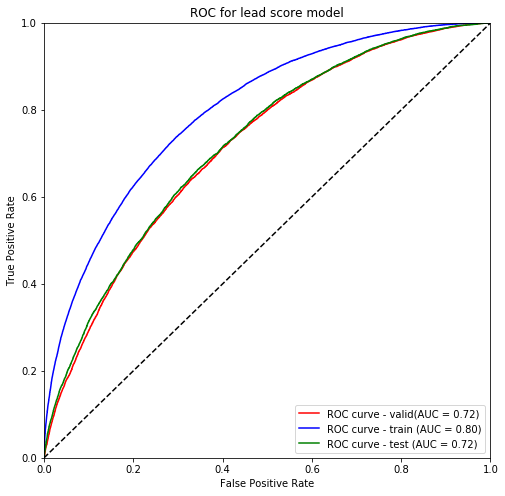

In [102]:
draw_ROC(gbm, dtrain, dvalid, dtest, y_train, y_valid, y_test)

### Distribution of predicted values

In [103]:
y_pred = gbm.predict(dtest)

In [105]:
print(y_pred.max(), y_pred.min(), y_pred.mean())

0.853932 0.0061690947 0.18438248


### Feature importance

In [106]:
importance=gbm.get_fscore()

In [107]:
df_importance = pd.DataFrame(importance.items(), columns=['feature', 'fscore'])
df_importance['fscore'] = df_importance['fscore'] / df_importance['fscore'].sum()

In [108]:
df_importance.sort_values(['fscore'], ascending=False, inplace=True)
df_importance

,feature,fscore
10,dti,0.038357
26,installment,0.034028
16,mosinoldrevtlop,0.030375
7,emptitle_freq,0.028819
61,zipcode,0.027939
...,...,...
101,numtl30dpd,0.000135
102,chargeoffwithin12mths,0.000135
89,applicationtype,0.000068
98,accnowdelinq,0.000068


<Figure size 2304x2304 with 0 Axes>

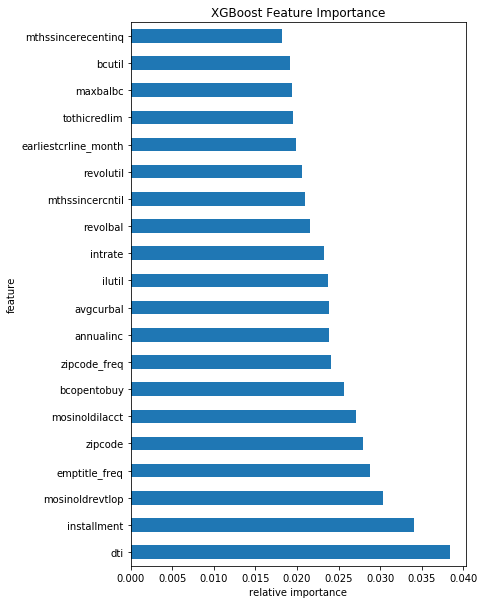

In [109]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance[:20].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

In [110]:
grade_importance = df_importance.query("feature=='grade'")
grade_importance

,feature,fscore
62,grade,0.001624


In [111]:
subgrade_importance = df_importance.query("feature=='subgrade'")
subgrade_importance

,feature,fscore
1,subgrade,0.007915


In [112]:
intrate_importance = df_importance.query("feature=='intrate'")
intrate_importance

,feature,fscore
0,intrate,0.023272


In [113]:
df_importance.query("feature=='loanamnt'")

,feature,fscore
27,loanamnt,0.017048


Text(0.5, 0, 'relative importance')

<Figure size 2304x2304 with 0 Axes>

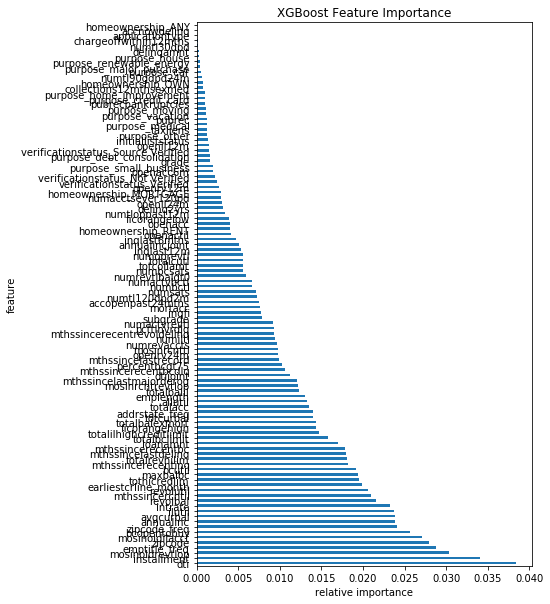

In [114]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

## Hyperparameter Tuning - Bayesian Optimization

In [118]:
!pip install bayesian-optimization

In [ ]:
from bayes_opt import BayesianOptimization

train_x = df_train[feat]
train_y = df_train.loanstatus

xgtrain = xgb.DMatrix(train_x, label=train_y, missing = np.NAN)  

def xgb_evaluate(min_child_weight,
                 colsample_bytree,
                 max_depth,
                 subsample,
                 gamma):
    params = dict()
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.05
    params['max_depth'] = int(max_depth )   
    params['min_child_weight'] = int(min_child_weight)
    params['colsample_bytree'] = colsample_bytree
    params['subsample'] = subsample
    params['gamma'] = gamma
    params['verbose_eval'] = False 



    cv_result = xgb.cv(params, xgtrain,
                       num_boost_round=100000,
                       nfold=3,
                       metrics={'auc'},
                       seed=1234,
                       callbacks=[xgb.callback.early_stop(50)])
    print(cv_result)

    return cv_result['test-auc-mean'].max()


xgb_BO = BayesianOptimization(xgb_evaluate, 
                             {'max_depth': (4, 8),
                              'min_child_weight': (0, 20),
                              'colsample_bytree': (0.2, 0.8),
                              'subsample': (0.5, 1),
                              'gamma': (0, 2)
                             }
                            )

xgb_BO.maximize(init_points=5, n_iter=40)

In [ ]:
## Tuning results
xgb_BO_scores = pd.DataFrame(xgb_BO.res['all']['params'])
xgb_BO_scores['score'] = pd.DataFrame(xgb_BO.res['all']['values'])
xgb_BO_scores = xgb_BO_scores.sort_values(by='score',ascending=False)
xgb_BO_scores.head(3)

In [114]:
%%time
# parameter set 1
params = {'objective': 'binary:logistic'
                  , 'booster': 'gbtree'
                  , 'eta': 0.01
                  , 'max_depth': 4     
                  , 'min_child_weight': 14   
                  , 'subsample': 0.7   
                  , 'colsample_bytree': 0.2457  
                  , 'gamma': 0.1751               
                  , 'seed': 1234
                  , 'nthread': -1
                  , 'silence': 1
                  , 'eval_metric': 'auc'
                  , 'scale_pos_weight': 1}

watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
num_boost_round=10000
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, early_stopping_rounds=50)

#[3101]	train-auc:0.749427	eval-auc:0.710863

[0]	train-auc:0.681797	eval-auc:0.679918
Multiple eval metrics have been passed: 'eval-auc' will be used for early stopping.

Will train until eval-auc hasn't improved in 50 rounds.
[1]	train-auc:0.685886	eval-auc:0.683554
[2]	train-auc:0.69015	eval-auc:0.686081
[3]	train-auc:0.692885	eval-auc:0.688434
[4]	train-auc:0.693864	eval-auc:0.688787
[5]	train-auc:0.694034	eval-auc:0.688564
[6]	train-auc:0.69594	eval-auc:0.690222
[7]	train-auc:0.695466	eval-auc:0.690189
[8]	train-auc:0.695123	eval-auc:0.690239
[9]	train-auc:0.695574	eval-auc:0.690624
[10]	train-auc:0.69511	eval-auc:0.690261
[11]	train-auc:0.696359	eval-auc:0.691347
[12]	train-auc:0.695827	eval-auc:0.690848
[13]	train-auc:0.696799	eval-auc:0.692011
[14]	train-auc:0.696727	eval-auc:0.69189
[15]	train-auc:0.696899	eval-auc:0.692061
[16]	train-auc:0.697296	eval-auc:0.69248
[17]	train-auc:0.697496	eval-auc:0.692531
[18]	train-auc:0.698195	eval-auc:0.693167
[19]	train-auc:0.698522	eval-auc:0.693403
[20]	train-auc:0.698533	eval-auc:0

[191]	train-auc:0.703803	eval-auc:0.697512
[192]	train-auc:0.703885	eval-auc:0.697552
[193]	train-auc:0.703946	eval-auc:0.697566
[194]	train-auc:0.70399	eval-auc:0.697608
[195]	train-auc:0.704038	eval-auc:0.697652
[196]	train-auc:0.704089	eval-auc:0.697669
[197]	train-auc:0.704148	eval-auc:0.697705
[198]	train-auc:0.704239	eval-auc:0.697786
[199]	train-auc:0.704246	eval-auc:0.697788
[200]	train-auc:0.704217	eval-auc:0.69776
[201]	train-auc:0.704293	eval-auc:0.697824
[202]	train-auc:0.704337	eval-auc:0.697865
[203]	train-auc:0.704343	eval-auc:0.697864
[204]	train-auc:0.704398	eval-auc:0.697897
[205]	train-auc:0.704497	eval-auc:0.697968
[206]	train-auc:0.704486	eval-auc:0.697963
[207]	train-auc:0.704495	eval-auc:0.697976
[208]	train-auc:0.704564	eval-auc:0.698018
[209]	train-auc:0.7046	eval-auc:0.698054
[210]	train-auc:0.70462	eval-auc:0.698085
[211]	train-auc:0.704613	eval-auc:0.69809
[212]	train-auc:0.704628	eval-auc:0.69811
[213]	train-auc:0.704639	eval-auc:0.698099
[214]	train-auc:0.

[383]	train-auc:0.708913	eval-auc:0.700897
[384]	train-auc:0.708926	eval-auc:0.7009
[385]	train-auc:0.70895	eval-auc:0.700915
[386]	train-auc:0.708983	eval-auc:0.700937
[387]	train-auc:0.709004	eval-auc:0.700939
[388]	train-auc:0.709035	eval-auc:0.700971
[389]	train-auc:0.709088	eval-auc:0.701011
[390]	train-auc:0.70912	eval-auc:0.701025
[391]	train-auc:0.709144	eval-auc:0.701034
[392]	train-auc:0.709162	eval-auc:0.701042
[393]	train-auc:0.709198	eval-auc:0.701067
[394]	train-auc:0.709266	eval-auc:0.70112
[395]	train-auc:0.709312	eval-auc:0.701154
[396]	train-auc:0.709312	eval-auc:0.701152
[397]	train-auc:0.709342	eval-auc:0.701151
[398]	train-auc:0.709352	eval-auc:0.701158
[399]	train-auc:0.709395	eval-auc:0.701188
[400]	train-auc:0.7094	eval-auc:0.701191
[401]	train-auc:0.709413	eval-auc:0.701189
[402]	train-auc:0.709462	eval-auc:0.701225
[403]	train-auc:0.709489	eval-auc:0.70124
[404]	train-auc:0.709519	eval-auc:0.701261
[405]	train-auc:0.709526	eval-auc:0.701274
[406]	train-auc:0.7

[575]	train-auc:0.714264	eval-auc:0.70385
[576]	train-auc:0.714283	eval-auc:0.703867
[577]	train-auc:0.714315	eval-auc:0.703884
[578]	train-auc:0.71435	eval-auc:0.703901
[579]	train-auc:0.714373	eval-auc:0.703917
[580]	train-auc:0.714387	eval-auc:0.703922
[581]	train-auc:0.714426	eval-auc:0.703935
[582]	train-auc:0.714452	eval-auc:0.703947
[583]	train-auc:0.714485	eval-auc:0.703959
[584]	train-auc:0.714513	eval-auc:0.703978
[585]	train-auc:0.71455	eval-auc:0.704003
[586]	train-auc:0.714576	eval-auc:0.704013
[587]	train-auc:0.714596	eval-auc:0.704012
[588]	train-auc:0.714625	eval-auc:0.704023
[589]	train-auc:0.714647	eval-auc:0.704032
[590]	train-auc:0.714676	eval-auc:0.704046
[591]	train-auc:0.714702	eval-auc:0.704067
[592]	train-auc:0.714735	eval-auc:0.70408
[593]	train-auc:0.714749	eval-auc:0.704084
[594]	train-auc:0.714777	eval-auc:0.704091
[595]	train-auc:0.714804	eval-auc:0.704103
[596]	train-auc:0.714822	eval-auc:0.70411
[597]	train-auc:0.71485	eval-auc:0.704121
[598]	train-auc:0

[767]	train-auc:0.718931	eval-auc:0.705851
[768]	train-auc:0.718955	eval-auc:0.705858
[769]	train-auc:0.71898	eval-auc:0.705868
[770]	train-auc:0.718999	eval-auc:0.705874
[771]	train-auc:0.71902	eval-auc:0.705891
[772]	train-auc:0.719041	eval-auc:0.705907
[773]	train-auc:0.719053	eval-auc:0.705912
[774]	train-auc:0.719073	eval-auc:0.70592
[775]	train-auc:0.719082	eval-auc:0.70592
[776]	train-auc:0.719106	eval-auc:0.705931
[777]	train-auc:0.719123	eval-auc:0.705942
[778]	train-auc:0.719143	eval-auc:0.705944
[779]	train-auc:0.719172	eval-auc:0.705948
[780]	train-auc:0.719195	eval-auc:0.705956
[781]	train-auc:0.719216	eval-auc:0.705969
[782]	train-auc:0.719228	eval-auc:0.705979
[783]	train-auc:0.719248	eval-auc:0.705986
[784]	train-auc:0.719269	eval-auc:0.705993
[785]	train-auc:0.71929	eval-auc:0.706001
[786]	train-auc:0.719317	eval-auc:0.706021
[787]	train-auc:0.71934	eval-auc:0.706022
[788]	train-auc:0.719363	eval-auc:0.706029
[789]	train-auc:0.719385	eval-auc:0.706034
[790]	train-auc:0

[959]	train-auc:0.722745	eval-auc:0.707211
[960]	train-auc:0.722761	eval-auc:0.707212
[961]	train-auc:0.722779	eval-auc:0.707217
[962]	train-auc:0.722794	eval-auc:0.707222
[963]	train-auc:0.722821	eval-auc:0.707229
[964]	train-auc:0.722838	eval-auc:0.707237
[965]	train-auc:0.722857	eval-auc:0.707242
[966]	train-auc:0.722869	eval-auc:0.70725
[967]	train-auc:0.722884	eval-auc:0.707255
[968]	train-auc:0.722902	eval-auc:0.707256
[969]	train-auc:0.722917	eval-auc:0.707257
[970]	train-auc:0.722934	eval-auc:0.70726
[971]	train-auc:0.722949	eval-auc:0.707266
[972]	train-auc:0.722966	eval-auc:0.707278
[973]	train-auc:0.722989	eval-auc:0.707289
[974]	train-auc:0.723004	eval-auc:0.707296
[975]	train-auc:0.72302	eval-auc:0.707297
[976]	train-auc:0.72304	eval-auc:0.7073
[977]	train-auc:0.723057	eval-auc:0.707307
[978]	train-auc:0.723076	eval-auc:0.707316
[979]	train-auc:0.723091	eval-auc:0.707317
[980]	train-auc:0.723112	eval-auc:0.707323
[981]	train-auc:0.723137	eval-auc:0.707328
[982]	train-auc:0

[1148]	train-auc:0.725819	eval-auc:0.707917
[1149]	train-auc:0.72583	eval-auc:0.707924
[1150]	train-auc:0.725847	eval-auc:0.707922
[1151]	train-auc:0.725865	eval-auc:0.707927
[1152]	train-auc:0.725873	eval-auc:0.707926
[1153]	train-auc:0.725893	eval-auc:0.707939
[1154]	train-auc:0.725911	eval-auc:0.707941
[1155]	train-auc:0.725915	eval-auc:0.707942
[1156]	train-auc:0.725931	eval-auc:0.707943
[1157]	train-auc:0.725946	eval-auc:0.707945
[1158]	train-auc:0.725969	eval-auc:0.707949
[1159]	train-auc:0.725983	eval-auc:0.707958
[1160]	train-auc:0.725999	eval-auc:0.707967
[1161]	train-auc:0.726018	eval-auc:0.707975
[1162]	train-auc:0.726035	eval-auc:0.707981
[1163]	train-auc:0.726044	eval-auc:0.707986
[1164]	train-auc:0.726058	eval-auc:0.70799
[1165]	train-auc:0.726074	eval-auc:0.70799
[1166]	train-auc:0.72609	eval-auc:0.707991
[1167]	train-auc:0.726104	eval-auc:0.707992
[1168]	train-auc:0.726127	eval-auc:0.707998
[1169]	train-auc:0.726147	eval-auc:0.708004
[1170]	train-auc:0.726159	eval-auc:0

[1336]	train-auc:0.728614	eval-auc:0.708562
[1337]	train-auc:0.728626	eval-auc:0.708565
[1338]	train-auc:0.72864	eval-auc:0.708565
[1339]	train-auc:0.728652	eval-auc:0.708565
[1340]	train-auc:0.728665	eval-auc:0.708575
[1341]	train-auc:0.728674	eval-auc:0.708572
[1342]	train-auc:0.728694	eval-auc:0.708572
[1343]	train-auc:0.728711	eval-auc:0.708573
[1344]	train-auc:0.728729	eval-auc:0.708575
[1345]	train-auc:0.728746	eval-auc:0.70858
[1346]	train-auc:0.728754	eval-auc:0.708583
[1347]	train-auc:0.728775	eval-auc:0.70859
[1348]	train-auc:0.728793	eval-auc:0.708596
[1349]	train-auc:0.7288	eval-auc:0.708597
[1350]	train-auc:0.728812	eval-auc:0.708604
[1351]	train-auc:0.728827	eval-auc:0.708608
[1352]	train-auc:0.728839	eval-auc:0.708612
[1353]	train-auc:0.728849	eval-auc:0.70862
[1354]	train-auc:0.728874	eval-auc:0.708627
[1355]	train-auc:0.728888	eval-auc:0.70863
[1356]	train-auc:0.728901	eval-auc:0.708633
[1357]	train-auc:0.72891	eval-auc:0.708639
[1358]	train-auc:0.72893	eval-auc:0.7086

[1524]	train-auc:0.731193	eval-auc:0.709003
[1525]	train-auc:0.731216	eval-auc:0.709009
[1526]	train-auc:0.73123	eval-auc:0.709012
[1527]	train-auc:0.731245	eval-auc:0.709019
[1528]	train-auc:0.731262	eval-auc:0.70902
[1529]	train-auc:0.731276	eval-auc:0.70902
[1530]	train-auc:0.731292	eval-auc:0.709026
[1531]	train-auc:0.731311	eval-auc:0.709034
[1532]	train-auc:0.731326	eval-auc:0.709034
[1533]	train-auc:0.731338	eval-auc:0.709038
[1534]	train-auc:0.731345	eval-auc:0.709038
[1535]	train-auc:0.731356	eval-auc:0.709041
[1536]	train-auc:0.731374	eval-auc:0.709048
[1537]	train-auc:0.731393	eval-auc:0.709061
[1538]	train-auc:0.731402	eval-auc:0.709064
[1539]	train-auc:0.731417	eval-auc:0.709063
[1540]	train-auc:0.731424	eval-auc:0.709063
[1541]	train-auc:0.731442	eval-auc:0.709069
[1542]	train-auc:0.731458	eval-auc:0.709073
[1543]	train-auc:0.731467	eval-auc:0.709069
[1544]	train-auc:0.731481	eval-auc:0.709067
[1545]	train-auc:0.731496	eval-auc:0.70907
[1546]	train-auc:0.731517	eval-auc:0

[1712]	train-auc:0.733697	eval-auc:0.709408
[1713]	train-auc:0.733707	eval-auc:0.709412
[1714]	train-auc:0.733718	eval-auc:0.70941
[1715]	train-auc:0.733749	eval-auc:0.70942
[1716]	train-auc:0.733758	eval-auc:0.709415
[1717]	train-auc:0.733769	eval-auc:0.709411
[1718]	train-auc:0.733781	eval-auc:0.709409
[1719]	train-auc:0.733795	eval-auc:0.709414
[1720]	train-auc:0.733807	eval-auc:0.709414
[1721]	train-auc:0.733823	eval-auc:0.709414
[1722]	train-auc:0.73383	eval-auc:0.709411
[1723]	train-auc:0.733842	eval-auc:0.709411
[1724]	train-auc:0.733856	eval-auc:0.709415
[1725]	train-auc:0.733868	eval-auc:0.709418
[1726]	train-auc:0.733875	eval-auc:0.709419
[1727]	train-auc:0.733885	eval-auc:0.709421
[1728]	train-auc:0.733906	eval-auc:0.709419
[1729]	train-auc:0.733925	eval-auc:0.709421
[1730]	train-auc:0.733933	eval-auc:0.70942
[1731]	train-auc:0.733944	eval-auc:0.709421
[1732]	train-auc:0.733952	eval-auc:0.709424
[1733]	train-auc:0.733959	eval-auc:0.709425
[1734]	train-auc:0.733978	eval-auc:0

[1900]	train-auc:0.736054	eval-auc:0.709695
[1901]	train-auc:0.736062	eval-auc:0.709696
[1902]	train-auc:0.736068	eval-auc:0.709697
[1903]	train-auc:0.736078	eval-auc:0.709698
[1904]	train-auc:0.736088	eval-auc:0.709693
[1905]	train-auc:0.736109	eval-auc:0.709696
[1906]	train-auc:0.736122	eval-auc:0.709704
[1907]	train-auc:0.736135	eval-auc:0.709703
[1908]	train-auc:0.736153	eval-auc:0.709712
[1909]	train-auc:0.736162	eval-auc:0.709711
[1910]	train-auc:0.736173	eval-auc:0.709712
[1911]	train-auc:0.736192	eval-auc:0.709721
[1912]	train-auc:0.736199	eval-auc:0.709723
[1913]	train-auc:0.736206	eval-auc:0.709725
[1914]	train-auc:0.736215	eval-auc:0.709725
[1915]	train-auc:0.736231	eval-auc:0.709727
[1916]	train-auc:0.736244	eval-auc:0.709731
[1917]	train-auc:0.736253	eval-auc:0.709733
[1918]	train-auc:0.736274	eval-auc:0.709735
[1919]	train-auc:0.736289	eval-auc:0.709738
[1920]	train-auc:0.736303	eval-auc:0.709738
[1921]	train-auc:0.736312	eval-auc:0.70975
[1922]	train-auc:0.73632	eval-auc

[2088]	train-auc:0.738419	eval-auc:0.710011
[2089]	train-auc:0.738432	eval-auc:0.710012
[2090]	train-auc:0.73844	eval-auc:0.710011
[2091]	train-auc:0.738451	eval-auc:0.710013
[2092]	train-auc:0.738458	eval-auc:0.710011
[2093]	train-auc:0.738473	eval-auc:0.710011
[2094]	train-auc:0.738486	eval-auc:0.710005
[2095]	train-auc:0.738505	eval-auc:0.710005
[2096]	train-auc:0.73852	eval-auc:0.710011
[2097]	train-auc:0.738536	eval-auc:0.710012
[2098]	train-auc:0.738555	eval-auc:0.710011
[2099]	train-auc:0.738569	eval-auc:0.71001
[2100]	train-auc:0.738583	eval-auc:0.710011
[2101]	train-auc:0.738594	eval-auc:0.71001
[2102]	train-auc:0.738608	eval-auc:0.71001
[2103]	train-auc:0.738621	eval-auc:0.710011
[2104]	train-auc:0.738633	eval-auc:0.710012
[2105]	train-auc:0.738647	eval-auc:0.710015
[2106]	train-auc:0.738654	eval-auc:0.710019
[2107]	train-auc:0.738672	eval-auc:0.71002
[2108]	train-auc:0.738684	eval-auc:0.71002
[2109]	train-auc:0.738688	eval-auc:0.710021
[2110]	train-auc:0.738704	eval-auc:0.71

[2276]	train-auc:0.74066	eval-auc:0.710218
[2277]	train-auc:0.740668	eval-auc:0.710219
[2278]	train-auc:0.740682	eval-auc:0.710223
[2279]	train-auc:0.740686	eval-auc:0.710222
[2280]	train-auc:0.740703	eval-auc:0.710223
[2281]	train-auc:0.740704	eval-auc:0.710222
[2282]	train-auc:0.740707	eval-auc:0.710227
[2283]	train-auc:0.740716	eval-auc:0.710231
[2284]	train-auc:0.740726	eval-auc:0.71023
[2285]	train-auc:0.740736	eval-auc:0.710226
[2286]	train-auc:0.740743	eval-auc:0.710225
[2287]	train-auc:0.740756	eval-auc:0.710226
[2288]	train-auc:0.740773	eval-auc:0.710222
[2289]	train-auc:0.74078	eval-auc:0.710224
[2290]	train-auc:0.740797	eval-auc:0.710227
[2291]	train-auc:0.74081	eval-auc:0.710223
[2292]	train-auc:0.74082	eval-auc:0.710224
[2293]	train-auc:0.740835	eval-auc:0.710229
[2294]	train-auc:0.740847	eval-auc:0.710229
[2295]	train-auc:0.740854	eval-auc:0.710227
[2296]	train-auc:0.740871	eval-auc:0.710228
[2297]	train-auc:0.740892	eval-auc:0.710232
[2298]	train-auc:0.740899	eval-auc:0.

[2464]	train-auc:0.742766	eval-auc:0.710379
[2465]	train-auc:0.742775	eval-auc:0.710384
[2466]	train-auc:0.742783	eval-auc:0.710381
[2467]	train-auc:0.742795	eval-auc:0.71038
[2468]	train-auc:0.742797	eval-auc:0.710377
[2469]	train-auc:0.742814	eval-auc:0.710381
[2470]	train-auc:0.742824	eval-auc:0.710381
[2471]	train-auc:0.742836	eval-auc:0.71038
[2472]	train-auc:0.742851	eval-auc:0.710375
[2473]	train-auc:0.742865	eval-auc:0.71038
[2474]	train-auc:0.742872	eval-auc:0.710378
[2475]	train-auc:0.74288	eval-auc:0.710376
[2476]	train-auc:0.742886	eval-auc:0.710375
[2477]	train-auc:0.742898	eval-auc:0.710375
[2478]	train-auc:0.74291	eval-auc:0.710369
[2479]	train-auc:0.742924	eval-auc:0.71037
[2480]	train-auc:0.742932	eval-auc:0.71037
[2481]	train-auc:0.742942	eval-auc:0.710372
[2482]	train-auc:0.742953	eval-auc:0.710375
[2483]	train-auc:0.742963	eval-auc:0.710377
[2484]	train-auc:0.742974	eval-auc:0.710379
[2485]	train-auc:0.742991	eval-auc:0.710376
[2486]	train-auc:0.742997	eval-auc:0.71

[2651]	train-auc:0.744717	eval-auc:0.710537
[2652]	train-auc:0.744734	eval-auc:0.710536
[2653]	train-auc:0.744738	eval-auc:0.710541
[2654]	train-auc:0.74475	eval-auc:0.710539
[2655]	train-auc:0.744763	eval-auc:0.71054
[2656]	train-auc:0.744774	eval-auc:0.71054
[2657]	train-auc:0.744784	eval-auc:0.710539
[2658]	train-auc:0.744799	eval-auc:0.710544
[2659]	train-auc:0.744814	eval-auc:0.710546
[2660]	train-auc:0.744824	eval-auc:0.710548
[2661]	train-auc:0.744833	eval-auc:0.710549
[2662]	train-auc:0.744842	eval-auc:0.710553
[2663]	train-auc:0.74485	eval-auc:0.710561
[2664]	train-auc:0.744863	eval-auc:0.710561
[2665]	train-auc:0.744869	eval-auc:0.710561
[2666]	train-auc:0.744882	eval-auc:0.710567
[2667]	train-auc:0.744888	eval-auc:0.710569
[2668]	train-auc:0.744902	eval-auc:0.710564
[2669]	train-auc:0.744905	eval-auc:0.710563
[2670]	train-auc:0.744916	eval-auc:0.710556
[2671]	train-auc:0.744926	eval-auc:0.710553
[2672]	train-auc:0.744937	eval-auc:0.710558
[2673]	train-auc:0.744955	eval-auc:0

[2839]	train-auc:0.746697	eval-auc:0.710644
[2840]	train-auc:0.746708	eval-auc:0.710647
[2841]	train-auc:0.746716	eval-auc:0.710646
[2842]	train-auc:0.746727	eval-auc:0.710647
[2843]	train-auc:0.746742	eval-auc:0.710651
[2844]	train-auc:0.746747	eval-auc:0.710649
[2845]	train-auc:0.746757	eval-auc:0.710651
[2846]	train-auc:0.746761	eval-auc:0.710654
[2847]	train-auc:0.746768	eval-auc:0.710654
[2848]	train-auc:0.746774	eval-auc:0.710654
[2849]	train-auc:0.746779	eval-auc:0.710655
[2850]	train-auc:0.746791	eval-auc:0.710654
[2851]	train-auc:0.7468	eval-auc:0.710655
[2852]	train-auc:0.746809	eval-auc:0.710659
[2853]	train-auc:0.746821	eval-auc:0.71066
[2854]	train-auc:0.746833	eval-auc:0.710662
[2855]	train-auc:0.746842	eval-auc:0.710666
[2856]	train-auc:0.746846	eval-auc:0.710668
[2857]	train-auc:0.746859	eval-auc:0.710675
[2858]	train-auc:0.746873	eval-auc:0.710674
[2859]	train-auc:0.746891	eval-auc:0.710676
[2860]	train-auc:0.746896	eval-auc:0.710676
[2861]	train-auc:0.746908	eval-auc:

[3026]	train-auc:0.748649	eval-auc:0.710803
[3027]	train-auc:0.74866	eval-auc:0.710803
[3028]	train-auc:0.748675	eval-auc:0.71081
[3029]	train-auc:0.748681	eval-auc:0.710813
[3030]	train-auc:0.748695	eval-auc:0.710816
[3031]	train-auc:0.748699	eval-auc:0.710818
[3032]	train-auc:0.748709	eval-auc:0.71082
[3033]	train-auc:0.748715	eval-auc:0.710822
[3034]	train-auc:0.748724	eval-auc:0.710823
[3035]	train-auc:0.748725	eval-auc:0.710826
[3036]	train-auc:0.748736	eval-auc:0.710829
[3037]	train-auc:0.748749	eval-auc:0.710835
[3038]	train-auc:0.748757	eval-auc:0.710837
[3039]	train-auc:0.748769	eval-auc:0.710839
[3040]	train-auc:0.748785	eval-auc:0.71084
[3041]	train-auc:0.748787	eval-auc:0.71084
[3042]	train-auc:0.748794	eval-auc:0.71084
[3043]	train-auc:0.748805	eval-auc:0.710842
[3044]	train-auc:0.748814	eval-auc:0.710842
[3045]	train-auc:0.748829	eval-auc:0.710839
[3046]	train-auc:0.748838	eval-auc:0.710845
[3047]	train-auc:0.748854	eval-auc:0.710838
[3048]	train-auc:0.748864	eval-auc:0.7

## train model with tuned parameters

In [115]:
best_xgb_iteration=3101
clf_train = xgb.XGBClassifier(learning_rate = 0.01
                  , n_estimators =best_xgb_iteration
                  , max_depth = 4
                  , min_child_weight = 14
                  , subsample = 0.7
                  , colsample_bytree = 0.2457
                  , gamma = 0.1751
                  , seed = 1234
                  , nthread = -1
                  , scale_pos_weight = 1
                  )

clf_train.fit(train_x, train_y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.2457,
       gamma=0.1751, learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=14, missing=None, n_estimators=3101, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=True, subsample=0.7)

## validate on test data

Area under the ROC curve - validation: 0.710863
Area under the ROC curve - train: 0.749427
Area under the ROC curve - test: 0.695323


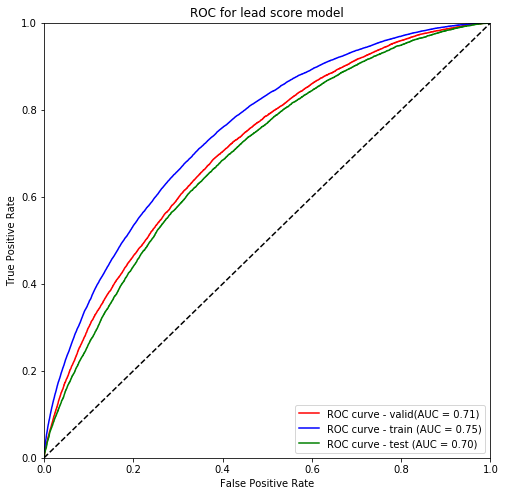

In [116]:
draw_ROC(gbm, dtrain, dvalid, dtest, y_train, y_valid, y_test)

In [117]:
y_pred = gbm.predict(dtest)

In [118]:
print y_pred.max(), y_pred.min(), y_pred.mean()

0.79729 0.00555161 0.168296


In [119]:
importance=gbm.get_fscore()

In [120]:
df_importance = pd.DataFrame(importance.items(), columns=['feature', 'fscore'])
df_importance['fscore'] = df_importance['fscore'] / df_importance['fscore'].sum()

In [121]:
df_importance.sort_values(['fscore'], ascending=False, inplace=True)
df_importance

,feature,fscore
25,installment,0.030167
64,dti,0.028382
84,zipcode,0.027795
14,maxbalbc,0.024813
63,intrate,0.024397
29,annualinc,0.023933
27,avgcurbal,0.023395
23,loanamnt,0.023028
28,mosinoldilacct,0.022344
13,tothicredlim,0.022271


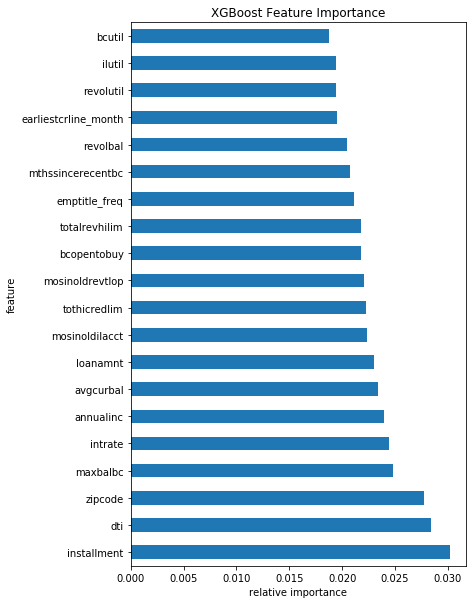

In [122]:
plt.figure(figsize=(32, 32))
# df_importance.plot()
df_importance[:20].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')

## Save model

In [123]:
import pickle

In [124]:
with open('model_tuned.pkl','wb') as pkl_file:
    pickle.dump(gbm, pkl_file)

In [125]:
from sklearn.externals import joblib
joblib.dump(gbm, "pima.joblib.dat")

['pima.joblib.dat']